<h1>Data Science Capstone - Final Project</h1>
<body><i>This project will examine Philadelphia neighborhoods to determine the optimal location to open an Italian restaurant.</i></body>

<h2>Background and Problem Statement</h2>
Location is a critical factor for any business, and restaurants in particular must take special consideration to examine the level of competition in the area before opening. On the one hand, lots of similar restaurants in a given area likely means there is sufficient demand for a similar service, while of course on the other hand opening a restaurant in that same area will result in higher level of competition, and potentially lower revenue. <br><br>
    This analysis will examine every neighborhood in Philadelphia to determine the optimal location to open an Italian restaurant, and seeks to address several key questions:
<ul>
    <li>What neighborhood has the highest concentration of Italian restarants?</li>
    <li>Are there neighborhoods with similar characteristics without a strong Italian restaurant presence that are likely to be amenable to a new restaurant opening in the area?</li>
</ul>
We will begin by examining the types of restaurants currently in each neighborhood, and then utilize k-means clustering unsupervised machine learning to identify areas that present the best opportunity to open a new Italian restaurant. 

<h2>Target Audience</h2>
This analysis will likely be of interest to the following groups of people:
<ul>
    <li>Business owners seeking to learn more about the business and restaurant distribution in Philadelphia.</li>
    <li>Data science students interested in learning how geolocation data and machine learning can be leveraged to solve a practical business problem .</li>
    <li>Government entities that wish to learn more about the restaurant distribution in Philadelphia</li>
</ul>

<h2>Data</h2>
This analysis will rely predominantly on the following datasaets:
<ul>
    <li>OpenDataPhilly to find geographical coordinates for Philadelphia neighborhoods</li>
    <li>Foursquare API to identify area restaurants in each neighborhood</li>
</ul>

<h2>Analysis</h2>
We will begin by importing geographical data from OpenDataPhilly to determine the coordinates for each neighborhood. As neighborhood boundaries are complicated, the coordinates are provided in a MultiPolygon geometry via a GeoJSON file. To simplify our analysis, we will calculate centroid for each neighborhood and use those coordinates to determine the venue density within a given radius for each neighborhood. While this is an imperfect solution as not every venue in each neighborhood will be within the given radius for that particular centroid, however it should be sufficient for our analysis in gaining general insights into the makeup of each neighborhood.
<br><br>
After our neighborhoods have been populated, we can then utilize those coordinates with the Foursquare API to determine the venues in each area. We will initially analyze the data in two ways - first by examining the top 10 most popular venue categories broken down by neighborhood. This will allow us to look more holistically at the popular food types in Philadelphia, and then break this down further by individual neighborhood. As we expect to be opening an Italian restaurant, we will pay particular attention to the neighborhoods with a high density of Italian restaurants. arecalculate the top 10 most popular  venue types in each area, and then analyze those where Italian restaurants are included. We will look at the ratings for these restaurants to determine if there are any high density areas where Italian restaurants have a particularly low rating.
<br><br>
Finally, we will conduct a k-means clustering analysis of all Philadelphia neighborhoods to identify potential similarities between areas and guide our decision if there are any areas that may be more amenable to a new Italian restaurant opening.During this analysis, we found that clustering based on all venue types provided us with no meaningful data or clusters, as nearly 90% of the data fell into a single cluster, with the rest split amongst the remaining clusters, regardless of the k chosen. For this reason, we have reduced the dataset to only examine restaurants, rather than all venue types. This decision results in some data being lost, but the clusters are much more instructional.

<script src="https://unpkg.com/@turf/turf@3.5.2/turf.min.js"></script>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

import seaborn as sns

!pip install geopandas
import geopandas as gpd # GeoDataFrame creation
print('Libraries imported.')

     |████████████████████████████████| 112kB 7.3MB/s eta 0:00:01
     |████████████████████████████████| 972kB 5.2MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 10.8MB/s eta 0:00:01     |█████████▉                      | 317kB 10.8MB/s eta 0:00:01     |███████████████████████████████ | 993kB 10.8MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 6.2MB/s eta 0:00:01    |████████████▊                   | 5.9MB 8.3MB/s eta 0:00:02     |███████████████▏                | 7.0MB 8.3MB/s eta 0:00:01█████▉               | 7.7MB 8.3MB/s eta 0:00:01
     |████████████████████████████████| 6.5MB 33.4MB/s eta 0:00:01
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6
Libraries imported.


In [2]:
neighborhooddf = gpd.read_file("Neighborhoods_Philadelphia.geojson")
neighborhooddf.head()

,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at,geometry
0,PENNYPACK_PARK,Pennypack Park,Pennypack Park,87084.285589,6.014076e+07,9,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ..."
1,OVERBROOK,Overbrook,Overbrook,57004.924607,7.692499e+07,138,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ..."
2,GERMANTOWN_SOUTHWEST,"Germantown, Southwest",Southwest Germantown,14880.743608,1.441867e+07,59,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ..."
3,EAST_PARKSIDE,East Parkside,East Parkside,10885.781535,4.231000e+06,129,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ..."
4,GERMANY_HILL,Germany Hill,Germany Hill,13041.939087,6.949968e+06,49,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.22722 40.03523, -75.22865 ..."


In [3]:
# copy Philly neighborhoods to new GeoDataFrame
phillypointsdf = neighborhooddf.copy()
#Find the centroids for multipolygon neighborhoods
phillypointsdf['Center_point'] = phillypointsdf['geometry'].centroid
#Extract lat and lon from the centerpoint
phillypointsdf["long"] = phillypointsdf.Center_point.map(lambda p: p.x)
phillypointsdf["lat"] = phillypointsdf.Center_point.map(lambda p: p.y)
phillypointsdf.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at,geometry,Center_point,long,lat
0,PENNYPACK_PARK,Pennypack Park,Pennypack Park,87084.285589,6.014076e+07,9,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ...",POINT (-75.04890 40.06979),-75.048898,40.069786
1,OVERBROOK,Overbrook,Overbrook,57004.924607,7.692499e+07,138,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ...",POINT (-75.25349 39.97866),-75.253486,39.978660
2,GERMANTOWN_SOUTHWEST,"Germantown, Southwest",Southwest Germantown,14880.743608,1.441867e+07,59,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ...",POINT (-75.16737 40.02359),-75.167375,40.023592
3,EAST_PARKSIDE,East Parkside,East Parkside,10885.781535,4.231000e+06,129,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ...",POINT (-75.20640 39.97397),-75.206404,39.973968
4,GERMANY_HILL,Germany Hill,Germany Hill,13041.939087,6.949968e+06,49,2013-03-19T17:41:50.507999+00:00,2013-03-19T17:41:50.743000+00:00,"MULTIPOLYGON (((-75.22722 40.03523, -75.22865 ...",POINT (-75.23042 40.03611),-75.230422,40.036115


In [4]:
#create new dataframe with only the neighborhood names and centroid coordinates
phillycoordinatesdf = phillypointsdf[['listname', 'lat', 'long']]
phillycoordinatesdf.head()

,listname,lat,long
0,Pennypack Park,40.069786,-75.048898
1,Overbrook,39.978660,-75.253486
2,"Germantown, Southwest",40.023592,-75.167375
3,East Parkside,39.973968,-75.206404
4,Germany Hill,40.036115,-75.230422


In [55]:
#rename listname column to be 'neighborhood'
phillycoordinatesdf.rename(columns = {'listname': 'neighborhood'}, inplace = True)
phillycoordinatesdf.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,neighborhood,lat,long
0,Pennypack Park,40.069786,-75.048898
1,Overbrook,39.978660,-75.253486
2,"Germantown, Southwest",40.023592,-75.167375
3,East Parkside,39.973968,-75.206404
4,Germany Hill,40.036115,-75.230422


In [6]:
phillycoordinatesdf.shape

(158, 3)

In [7]:
address = 'Philadelphia, PA'

geolocator = Nominatim(user_agent="philly_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Philadelphia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Philadelphia are 39.9527237, -75.1635262.


In [8]:
# create map of Philadelphia using latitude and longitude values
map_philly = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for long, lat, neighborhood in zip(phillycoordinatesdf['long'], phillycoordinatesdf['lat'], phillycoordinatesdf['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_philly)  
    
map_philly

In [9]:
#import Foursquare credentials
CLIENT_ID = 'T5QRTXJZJMUKR1KZ13IN0J1SMMP2Q05ZBT0PEHDVLTBZERYC' # your Foursquare ID
CLIENT_SECRET = 'TAWC2ZKYXQZZC2YUXWUUM0GC5CX1UQOLNDFH5XUHIOEC3I3H' # your Foursquare Secret
ACCESS_TOKEN = 'R4UIAEIBYW1ICPGNLVHUSIMEE15P2JSE0CPKKJGGCUWNJTNA' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: T5QRTXJZJMUKR1KZ13IN0J1SMMP2Q05ZBT0PEHDVLTBZERYC
CLIENT_SECRET:TAWC2ZKYXQZZC2YUXWUUM0GC5CX1UQOLNDFH5XUHIOEC3I3H


In [12]:
#create function to loop through all Philly neighborhoods and find top venues at each
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
philly_venues = getNearbyVenues(names=phillycoordinatesdf['neighborhood'],
                                   latitudes=phillycoordinatesdf['lat'],
                                   longitudes=phillycoordinatesdf['long']
                                  )
print('All done!')

All done!


In [14]:
print(philly_venues.shape)
philly_venues.head()

(2867, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pennypack Park,40.069786,-75.048898,bells market,40.068580,-75.051452,Supermarket
1,Pennypack Park,40.069786,-75.048898,T-Mobile,40.072656,-75.048403,Mobile Phone Shop
2,Pennypack Park,40.069786,-75.048898,Dunkin',40.066239,-75.051570,Donut Shop
3,Pennypack Park,40.069786,-75.048898,Dollar Tree,40.069634,-75.051503,Discount Store
4,Pennypack Park,40.069786,-75.048898,Bustleton Avenue & Tustin Street,40.070935,-75.049478,Intersection


In [15]:
('There are {} uniques categories.'.format(len(philly_venues['Venue Category'].unique())))

'There are 305 uniques categories.'

In [16]:
# Create a dataframe to only focus on restaurants
philly_restaurants = philly_venues[philly_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
philly_restaurants.index = np.arange(1, len(philly_restaurants)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", philly_restaurants.shape)
philly_restaurants.head()

Shape of the Data-Frame with Venue Category only Restaurant:  (571, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Pennypack Park,40.069786,-75.048898,Lemon Leaf,40.065762,-75.050980,Thai Restaurant
2,Overbrook,39.978660,-75.253486,King Garden Chinese Resturant,39.976881,-75.252350,Chinese Restaurant
3,Overbrook,39.978660,-75.253486,65th Street Deli Food Market,39.977956,-75.250318,Restaurant
4,Overbrook,39.978660,-75.253486,R&M Deli & Soul Food,39.974440,-75.251741,Caribbean Restaurant
5,"Germantown, Southwest",40.023592,-75.167375,Beijing Garden,40.022558,-75.162057,Chinese Restaurant


In [18]:
# one hot encoding
philly_onehot = pd.get_dummies(philly_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
philly_onehot['Neighborhood'] = philly_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [philly_onehot.columns[-1]] + list(philly_onehot.columns[:-1])
philly_onehot = philly_onehot[fixed_columns]

print(philly_onehot.shape)
philly_onehot.head()

(571, 58)


,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
1,Pennypack Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Overbrook,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Overbrook,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Overbrook,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Germantown, Southwest",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
#count the venue type occurences for each neighborhood
venue_counts = philly_onehot.groupby('Neighborhood').sum()
venue_counts.head()

,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allegheny West,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bella Vista,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,7,0,0,0,0,1,7,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,1,0,4
Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Burholme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Callowhill,0,0,1,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,2


In [20]:
venue_counts['Italian Restaurant'].describe()

count    108.000000
mean       0.453704
std        1.113924
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.000000
Name: Italian Restaurant, dtype: float64

In [21]:
italian_venue_counts = venue_counts[['Italian Restaurant']]
italian_sorted = italian_venue_counts.sort_values(by = 'Italian Restaurant', ascending = False)
italian_sortedtop_10 = italian_sorted[0:9]
italian_sortedtop_10

,Italian Restaurant
Neighborhood,
Bella Vista,7
East Passyunk,5
Queen Village,4
Hawthorne,4
Society Hill,3
Fairmount,3
Washington Square West,2
Newbold,2
Rittenhouse,2


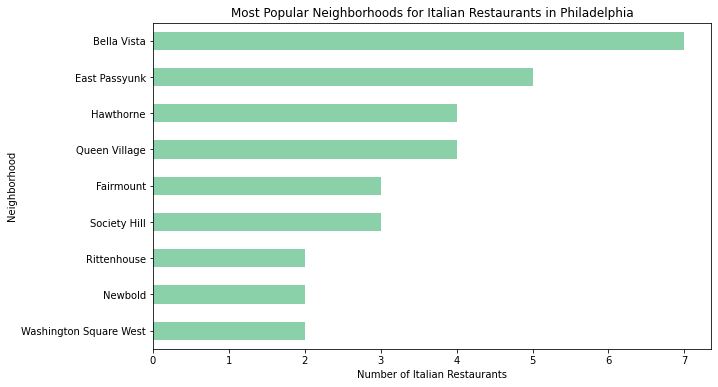

In [22]:
#Flip the order to make most popular neighborhoods first, and then plot
reversetop10 = italian_sortedtop_10.sort_values(by = 'Italian Restaurant', ascending = True)
reversetop10.plot(kind = 'barh', legend = None, figsize = (10,6), alpha = .6, color = 'mediumseagreen')
plt.xlabel('Number of Italian Restaurants')
plt.ylabel('Neighborhood')
plt.title('Most Popular Neighborhoods for Italian Restaurants in Philadelphia')
plt.show()

In [23]:
philly_grouped = philly_onehot.groupby('Neighborhood').mean().reset_index()
print(philly_grouped.shape)
philly_grouped.head()

(108, 58)


,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Allegheny West,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,Bella Vista,0.0,0.037037,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.259259,0.0,0.000000,0.000000,0.0,0.037037,0.259259,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.074074,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.037037,0.0,0.037037,0.0,0.148148
2,Belmont,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,Burholme,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,Callowhill,0.0,0.000000,0.058824,0.0,0.0,0.0,0.0,0.0,0.294118,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.058824,0.058824,0.0,0.000000,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.058824,0.000000,0.0,0.058824,0.0,0.0,0.058824,0.0,0.0,0.000000,0.0,0.000000,0.0,0.117647


In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = philly_grouped['Neighborhood']

for ind in np.arange(philly_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(philly_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(108, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allegheny West,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
1,Bella Vista,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Thai Restaurant,German Restaurant,French Restaurant,Mediterranean Restaurant
2,Belmont,Seafood Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
3,Burholme,Sushi Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
4,Callowhill,Chinese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,South American Restaurant,Ramen Restaurant,Restaurant,Latin American Restaurant,Korean Restaurant,Sushi Restaurant,Asian Restaurant


In [26]:
philly_grouped_clustering = philly_grouped.drop('Neighborhood', 1)

#Find the optimal number of clusters for k-means clustering
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(philly_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 

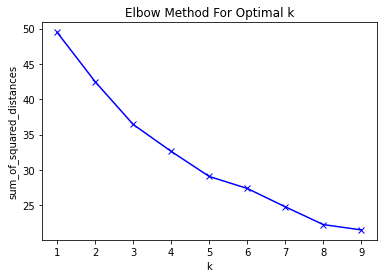

In [27]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [40]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(philly_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 1, 2, 5, 5, 5, 5, 5, 1], dtype=int32)

In [41]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Allegheny West,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
1,0,Bella Vista,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Thai Restaurant,German Restaurant,French Restaurant,Mediterranean Restaurant
2,1,Belmont,Seafood Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
3,2,Burholme,Sushi Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
4,5,Callowhill,Chinese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,South American Restaurant,Ramen Restaurant,Restaurant,Latin American Restaurant,Korean Restaurant,Sushi Restaurant,Asian Restaurant


In [43]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

philly_merged = phillycoordinatesdf

# merge philly_grouped with philly_data to add latitude/longitude for each neighborhood
philly_merged = philly_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')

print(philly_merged.shape)
philly_merged.head()

(158, 14)


,neighborhood,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pennypack Park,40.069786,-75.048898,5.0,Thai Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
1,Overbrook,39.978660,-75.253486,5.0,Caribbean Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
2,"Germantown, Southwest",40.023592,-75.167375,1.0,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
3,East Parkside,39.973968,-75.206404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Germany Hill,40.036115,-75.230422,4.0,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


In [44]:
philly_merged = philly_merged.dropna()
philly_merged.shape

(108, 14)

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(philly_merged['lat'], philly_merged['long'], philly_merged['neighborhood'], philly_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [49]:
philly_onehot.groupby('Neighborhood').sum().head()

,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allegheny West,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bella Vista,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,7,0,0,0,0,1,7,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,1,0,4
Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Burholme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Callowhill,0,0,1,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,2


In [51]:
philly_merged[['neighborhood', 'Cluster Labels']]
philly_merged.head()

,neighborhood,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pennypack Park,40.069786,-75.048898,5.0,Thai Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
1,Overbrook,39.978660,-75.253486,5.0,Caribbean Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
2,"Germantown, Southwest",40.023592,-75.167375,1.0,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
4,Germany Hill,40.036115,-75.230422,4.0,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
8,Wissahickon Hills,40.040245,-75.219074,2.0,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant


In [58]:
clusterdata = pd.merge(philly_onehot.groupby('Neighborhood').sum(),philly_merged[['neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata

Cluster Labels,0.0,1.0,2.0,3.0,4.0,5.0
American Restaurant,7,2,1,1,7,26
Asian Restaurant,4,1,1,0,0,19
Brazilian Restaurant,0,2,0,0,0,1
Cajun / Creole Restaurant,0,0,0,0,0,1
Cambodian Restaurant,0,0,0,0,0,2
Caribbean Restaurant,0,6,1,0,0,4
Caucasian Restaurant,0,0,0,0,0,1
Chinese Restaurant,1,2,5,16,0,49
Colombian Restaurant,0,0,0,0,0,1
Comfort Food Restaurant,0,0,0,0,0,1


In [59]:
cluster0 = philly_merged.loc[philly_merged['Cluster Labels'] == 0, philly_merged.columns[[0] + list(range(4, philly_merged.shape[1]))]]
cluster0.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bella Vista,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Thai Restaurant,German Restaurant,French Restaurant,Mediterranean Restaurant
20,Pennsport,American Restaurant,Italian Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
23,Winchester Park,Italian Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
29,Hawthorne,Vietnamese Restaurant,Italian Restaurant,Mexican Restaurant,Thai Restaurant,Indonesian Restaurant,Brazilian Restaurant,Ethiopian Restaurant,Halal Restaurant,American Restaurant,Greek Restaurant
63,Torresdale,Italian Restaurant,Asian Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant


In [60]:
cluster1 = philly_merged.loc[philly_merged['Cluster Labels'] == 1, philly_merged.columns[[0] + list(range(4, philly_merged.shape[1]))]]
cluster1.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Germantown, Southwest",Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
12,Glenwood,Caribbean Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
17,Garden Court,Seafood Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Vietnamese Restaurant,English Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant
18,Belmont,Seafood Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
26,Dunlap,Caribbean Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


In [61]:
cluster2 = philly_merged.loc[philly_merged['Cluster Labels'] == 2, philly_merged.columns[[0] + list(range(4, philly_merged.shape[1]))]]
cluster2.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Wissahickon Hills,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
11,Allegheny West,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
14,Francisville,Vietnamese Restaurant,Sushi Restaurant,Fast Food Restaurant,Seafood Restaurant,Dutch Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
24,Burholme,Sushi Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
25,Fern Rock,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant


In [62]:
cluster3 = philly_merged.loc[philly_merged['Cluster Labels'] == 3, philly_merged.columns[[0] + list(range(4, philly_merged.shape[1]))]]
cluster3.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Penrose,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
27,Melrose Park Gardens,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
28,Franklinville,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
39,Grays Ferry,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
76,Tacony,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


In [63]:
cluster4 = philly_merged.loc[philly_merged['Cluster Labels'] == 4, philly_merged.columns[[0] + list(range(4, philly_merged.shape[1]))]]
cluster4.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Germany Hill,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
9,Wissinoming,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
45,Mantua,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
48,Roxborough Park,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
91,Ogontz,American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


In [64]:
cluster5 = philly_merged.loc[philly_merged['Cluster Labels'] == 5, philly_merged.columns[[0] + list(range(4, philly_merged.shape[1]))]]
cluster5.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pennypack Park,Thai Restaurant,Vietnamese Restaurant,Dutch Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
1,Overbrook,Caribbean Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
13,Greenwich,Asian Restaurant,Cambodian Restaurant,Chinese Restaurant,Vietnamese Restaurant,English Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
16,Powelton,Middle Eastern Restaurant,New American Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
22,West Oak Lane,Southern / Soul Food Restaurant,Chinese Restaurant,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant


In [107]:
#Flip the order to make most popular neighborhoods first, and then plot
cluster1.plot(kind = 'hist', legend = None, figsize = (10,6), alpha = .6, color = 'mediumseagreen')
plt.xlabel('Restaurants')
plt.ylabel('Neighborhood')
plt.title('Most Popular Neighborhoods for Italian Restaurants in Philadelphia')
plt.show()

TypeError: no numeric data to plot

In [ ]:
#Do one hot encoding for clusters and plot histogram to see frequency of restaurants in those areas